In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization

from numba import njit

import copy

import numpy as np
import scipy as scy
import math as math

In [56]:
kB = 1.380e-23 # J/K
T = 293.15 #K
gamma = 50 #kg/(mol*ns)
mass = 0.018 #kg/mol
 
avogadro = 6.022e23 # 1/mol

In [57]:
def fixedtemp_velocities(target_temp, mass):
    """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
    kin_energy = kB * target_temp
    velocity = np.sqrt(2 * (kin_energy) / (mass / avogadro))
    return velocity

In [117]:
def langevin(starting_position, samples, temp, gamma, mass, angle:float|None = None, delta_t = 1e-6, rng_seed = None):
    particle_pos = np.zeros((2,samples+1))
    particle_vel = np.zeros((2,samples+1))

    particle_pos[:,0] = starting_position
    
    
    # Random Number Generator used with seed
    rng = np.random.default_rng(seed=rng_seed)

    if angle == None:
        angle = rng.uniform(0,2 * np.pi, 1)[0]

    starting_velocity = fixedtemp_velocities(temp, mass)

    particle_vel[0,0] = np.sin(angle) * starting_velocity
    particle_vel[1,0] = np.cos(angle) * starting_velocity

    for i in tqdm(range(samples)):
        # calculate the coressponding velocities
        rand_k = rng.normal(0,1,2)
        
        particle_pos[:,i+1] = particle_pos[:,i] + particle_vel[:,i]*delta_t
        
        particle_vel[0,i+1] = particle_vel[0,i] - (1/mass)*(gamma*particle_vel[0,i]*delta_t - np.sqrt(2*(gamma*avogadro)*kB*temp*delta_t)*rand_k[0])
        particle_vel[1,i+1] = particle_vel[1,i] - (1/mass)*(gamma*particle_vel[1,i]*delta_t - np.sqrt(2*(gamma*avogadro)*kB*temp*delta_t)*rand_k[1])
    return particle_pos, particle_vel


In [127]:
pos, vel = langevin(starting_position=np.array([0,0]), samples=10000000, temp=T, gamma=gamma, mass=mass)

100%|██████████| 10000000/10000000 [00:58<00:00, 170460.92it/s]


In [128]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

In [129]:
cmap = plt.cm.plasma  # Choose a colormap

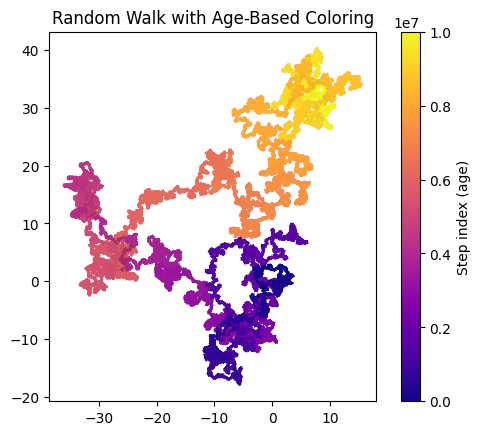

In [130]:
# Create segments for the random walk
points = pos.T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Define the age-based colors
norm = Normalize(vmin=0, vmax=pos.shape[1] - 1)  # Normalize based on number of points
cmap = plt.cm.plasma  # Choose a colormap

# Create a LineCollection
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(np.arange(pos.shape[1]))  # Use indices to colorize
lc.set_linewidth(2)  # Optional: Adjust line width

# Plot using LineCollection
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()  # Adjust plot limits to fit data
ax.set_aspect('equal')

# Add a colorbar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Step index (age)')

plt.title('Random Walk with Age-Based Coloring')
plt.show()

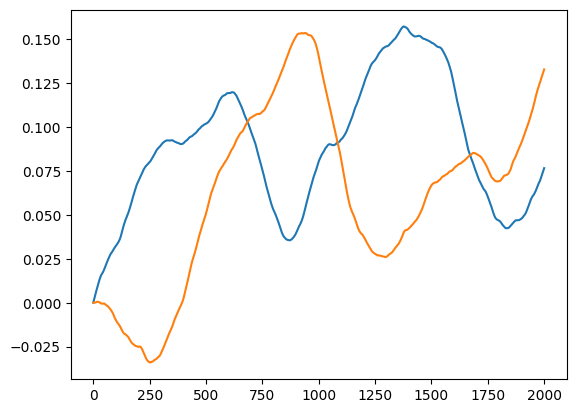

In [111]:
plt.plot(pos[0])
plt.plot(pos[1])